In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
import pathlib
from sklearn.preprocessing import LabelEncoder

C:\Users\thaim\anaconda3\envs\tf210\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [30]:
#importing dataset
p_train = tf.keras.utils.image_dataset_from_directory(
    "dataset/preprocessed/preprocessed_train",
    seed=42,
    batch_size=50,
    image_size=(224,224),
    label_mode="categorical"
)
p_val = tf.keras.utils.image_dataset_from_directory(
    "dataset/preprocessed/preprocessed_val",
    seed=42,
    batch_size=50,
    image_size=(224,224),
    label_mode="categorical"
)
ds_train2 = tf.keras.utils.image_dataset_from_directory(
    "dataset/kaggle_ds/retinopathy_dataset/gaussian_filtered_images/gaussian_filtered_images",
    seed=42,
    batch_size=50,
    image_size=(224,224),
    label_mode="categorical"
)


Found 3540 files belonging to 5 classes.
Found 1770 files belonging to 5 classes.
Found 3662 files belonging to 5 classes.


In [31]:
#normalization
def normalize_img(img, label):
    img = tf.cast(img, tf.float32)
    img = img / 255.0
    return img, label
p_train_n = p_train.map(
    normalize_img,
    num_parallel_calls=tf.data.AUTOTUNE
)
p_val_n = p_val.map(
    normalize_img,
    num_parallel_calls=tf.data.AUTOTUNE
)
train2_n = ds_train2.map(
    normalize_img,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [32]:
p_train_n,len(p_val_n)

(<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 36)

In [33]:
for b_imgs,_ in p_train_n.take(1):
    print(tf.reduce_max(b_imgs))
for b_imgs,_ in p_val_n.take(1):
    print(tf.reduce_max(b_imgs))

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [34]:
#splitting dataset
def split_data(data):
    data_size = len(data)
    split = 0.2
    val_size = int(data_size*split)
    
    shuffled = data.shuffle(buffer_size = data_size, seed=42)
    
    val = shuffled.take(val_size)
    train = shuffled.skip(val_size)
    
    val = val.unbatch().batch(50).prefetch(tf.data.AUTOTUNE)
    train = train.unbatch().batch(50).prefetch(tf.data.AUTOTUNE)
    return train,val
x,x_test = split_data(p_train_n)
kg_x,kg_x_test = split_data(ds_train2)
#print(len(x),len(y_test))

In [35]:
def grayscale(img,label):
    gray = tf.image.rgb_to_grayscale(img)
    return gray, label
x_grscl = x.map(grayscale, num_parallel_calls=tf.data.AUTOTUNE)
x_test_grscl = x_test.map(grayscale, num_parallel_calls=tf.data.AUTOTUNE)
p_val_grscl = p_val_n.map(grayscale, num_parallel_calls=tf.data.AUTOTUNE)
x_grscl,p_val_grscl

(<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

In [99]:
num_train_imgs = sum(1 for _ in x_grscl.unbatch())
batch_size     = 50
epochs         = 100
initial_lr     = 1e-3

steps_per_epoch = (num_train_imgs + batch_size - 1) // batch_size
decay_steps     = steps_per_epoch * epochs

cosine_decay = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    alpha=0.0
)

def lr_fn(epoch, lr):
    global_step = epoch * steps_per_epoch
    return float(cosine_decay(global_step).numpy())

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_fn, verbose=1)

In [100]:
lr_schedule_experimental = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-3 * 10**(epoch/20))

In [103]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=1,kernel_size=(3,3),activation="relu",input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation="relu"),
    tf.keras.layers.Dense(units = len(p_train.class_names), activation = "softmax")

])
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)
h1 = model_1.fit(x_grscl,validation_data = x_test_grscl, epochs=25,verbose=1
                ,callbacks=[lr_schedule])
#model_1.save(f"{os.getcwd()}/models/diabetic_multi-class_model_1")


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
57/57 [==============================] - 15s 152ms/step - loss: 1.5884 - accuracy: 0.2514 - val_loss: 1.4868 - val_accuracy: 0.3786 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009997532470151782.
Epoch 2/25
57/57 [==============================] - 14s 167ms/step - loss: 1.4499 - accuracy: 0.3856 - val_loss: 1.2957 - val_accuracy: 0.5414 - lr: 9.9975e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000999013427644968.
Epoch 3/25
57/57 [==============================] - 15s 160ms/step - loss: 1.2539 - accuracy: 0.5161 - val_loss: 1.0555 - val_accuracy: 0.6314 - lr: 9.9901e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000997781055048108.
Epoch 4/25
57/57 [==============================] - 15s 167ms/step - loss: 1.0028 - accuracy: 0.6449 - val_loss: 0.7995 - val_accuracy: 0.7600 - lr: 9.9778e-04

Epoch 5: LearningRateScheduler setting learni

In [ ]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(p_train.class_names), activation='softmax')
])
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics = ['accuracy']
)
h2 = model_2.fit(x_grscl,validation_data = x_test_grscl, epochs=epochs,verbose=1)
#model_2.save(f"{os.getcwd()}/models/diabetic_multi-class_model_2")

In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

model_3 = Sequential([
    # ── Augmentation & scaling ───────────────────────────
    layers.InputLayer((224,224,1)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # ── Conv block 1 ────────────────────────────────────
    layers.Conv2D(32, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ── Conv block 2 ────────────────────────────────────
    layers.Conv2D(64, 3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ── Conv block 3 ────────────────────────────────────
    layers.Conv2D(128,3, padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    # ── Head ────────────────────────────────────────────
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(len(p_train.class_names), activation="softmax")
])

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=["accuracy"]
)

# Callbacks: stop if no val_loss improvement, reduce LR on plateau
earlystop = EarlyStopping(
    monitor="val_loss", patience=7, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6
)

h3 = model_3.fit(
    x_grscl,
    validation_data=x_test_grscl,
    epochs=epochs,
    callbacks=[reduce_lr],
    verbose=1
)

#model_3.save("models/diabetic_multi-class_model_3")


In [ ]:
h3 = model_3.fit(
    x_grscl,
    validation_data=x_test_grscl,
    epochs=40,
    verbose=1,
    callbacks=[lr_schedule]
)
#model_3.save("models/diabetic_multi-class_model_3")

In [ ]:

num_classes = len(p_train.class_names)

tf.random.set_seed(42)
model_4 = tf.keras.Sequential([
    # ── Preprocessing ────────────────────────────────────────────
    tf.keras.layers.InputLayer((224,224,1)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),        
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

    # ── Conv block 1 ────────────────────────────────────────────
    tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # ── Conv block 2 ────────────────────────────────────────────
    tf.keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    # ── Conv block 3 ────────────────────────────────────────────
    tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),

    # ── Classification head ─────────────────────────────────────
    tf.keras.layers.GlobalAveragePooling2D(),     # collapse H×W→1, far fewer params than Flatten
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_4.summary()
h4 = model_4.fit(
    x_grscl,
    validation_data=x_test_grscl,
    epochs=epochs,
    verbose=1
)
#model_4.save(f"{os.getcwd()}/models/diabetic_multi-class_model_3")

In [ ]:
#Debugging for models guessing problem, checking the preprocessed images
for b_imgs,b_labels in p_val_grscl.take(1):
    for img in b_imgs:
        plt.imshow(img,cmap="gray" if img[0].ndim == 2 else None)
        plt.title(f"Image.ndim = {img[0].ndim}")
        plt.axis("off")
        plt.show()
        break;
for b_imgs,b_labels in x_grscl.take(1):
    for img in b_imgs:
        plt.imshow(img,cmap="gray" if img[0].ndim == 2 else None)
        plt.title(f"Image.ndim = {img[0].ndim}")
        plt.axis("off")
        plt.show()
        break;

In [91]:
#model_1 = tf.keras.models.load_model(f"{os.getcwd()}/models/diabetic_multi-class_model_1")
#model_1.evaluate(p_val_grscl)

INFO:tensorflow:Assets written to: C:\Users\thaim\Documents\Machine learning/models/diabetic_mutlti-class_model_2\assets


INFO:tensorflow:Assets written to: C:\Users\thaim\Documents\Machine learning/models/diabetic_mutlti-class_model_2\assets


In [74]:
# Prepare the history DataFrame
def plot_modelMetrics(h,title="model metrics",fname="model_metrics.png"):
    df = pd.DataFrame(h.history)
    num_epochs = len(df)
    step       = max(1, num_epochs // 10)
    positions  = list(range(0, num_epochs, step))
    
    # Dark background style
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(
        1, 2,
        figsize=(14, 6),
        dpi=300,
        facecolor='black'
    )
    for ax in (ax1, ax2):
        ax.set_facecolor('black')
        ax.grid(True, color='#555555', linestyle='--', linewidth=0.5)
    
    # ─── Accuracy subplot ────────────────────────────────────────────
    ax1.plot(
        df['accuracy'],marker="x",markersize=4, linewidth=1, color='#39FF14',
        label='Train Acc'
    )
    ax1.plot(
        df['val_accuracy'],marker="x",markersize=4,linewidth=1, color='#FF0090',
        label='Val Acc'
    )
    ax1.set_title('Accuracy', color='#39FF14', fontsize=16, pad=10)
    ax1.set_xlabel('Epoch', color='#39FF14')
    ax1.set_ylabel('Accuracy', color='#39FF14')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(positions)
    ax1.set_xticklabels(positions, rotation=45, color='#39FF14')
    ax1.tick_params(axis='y', colors='#39FF14')
    leg1 = ax1.legend(facecolor='black', edgecolor='#39FF14')
    for text in leg1.get_texts(): text.set_color('#39FF14')
    
    # ─── Loss subplot ─────────────────────────────────────────────────
    ax2.plot(
        df['loss'],marker="x",markersize=4 ,linewidth=1, color='#00FFFF',
        label='Train Loss'
    )
    ax2.plot(
        df['val_loss'],marker="x",markersize=4, linewidth=1, color='#FFA500',
        label='Val Loss'
    )
    ax2.set_title('Loss', color='#00FFFF', fontsize=16, pad=10)
    ax2.set_xlabel('Epoch', color='#00FFFF')
    ax2.set_ylabel('Loss', color='#00FFFF')
    # autoscale y to data range, with a little padding
    ymin = df2[['loss','val_loss']].min().min() * 0.9
    ymax = df2[['loss','val_loss']].max().max() * 1.1
    ax2.set_ylim(ymin, ymax)
    ax2.set_xticks(positions)
    ax2.set_xticklabels(positions, rotation=45, color='#00FFFF')
    ax2.tick_params(axis='y', colors='#00FFFF')
    leg2 = ax2.legend(facecolor='black', edgecolor='#00FFFF')
    for text in leg2.get_texts(): text.set_color('#00FFFF')
    
    # Supertitle and layout
    fig.suptitle(title, color='white', fontsize=18, y=1.02)
    plt.tight_layout()
    
    # Display
    plt.show()
    
    # Save the figure
    fig.savefig(
        fname,
        dpi=300,
        facecolor=fig.get_facecolor(),
        edgecolor='black',
        bbox_inches='tight'
    )


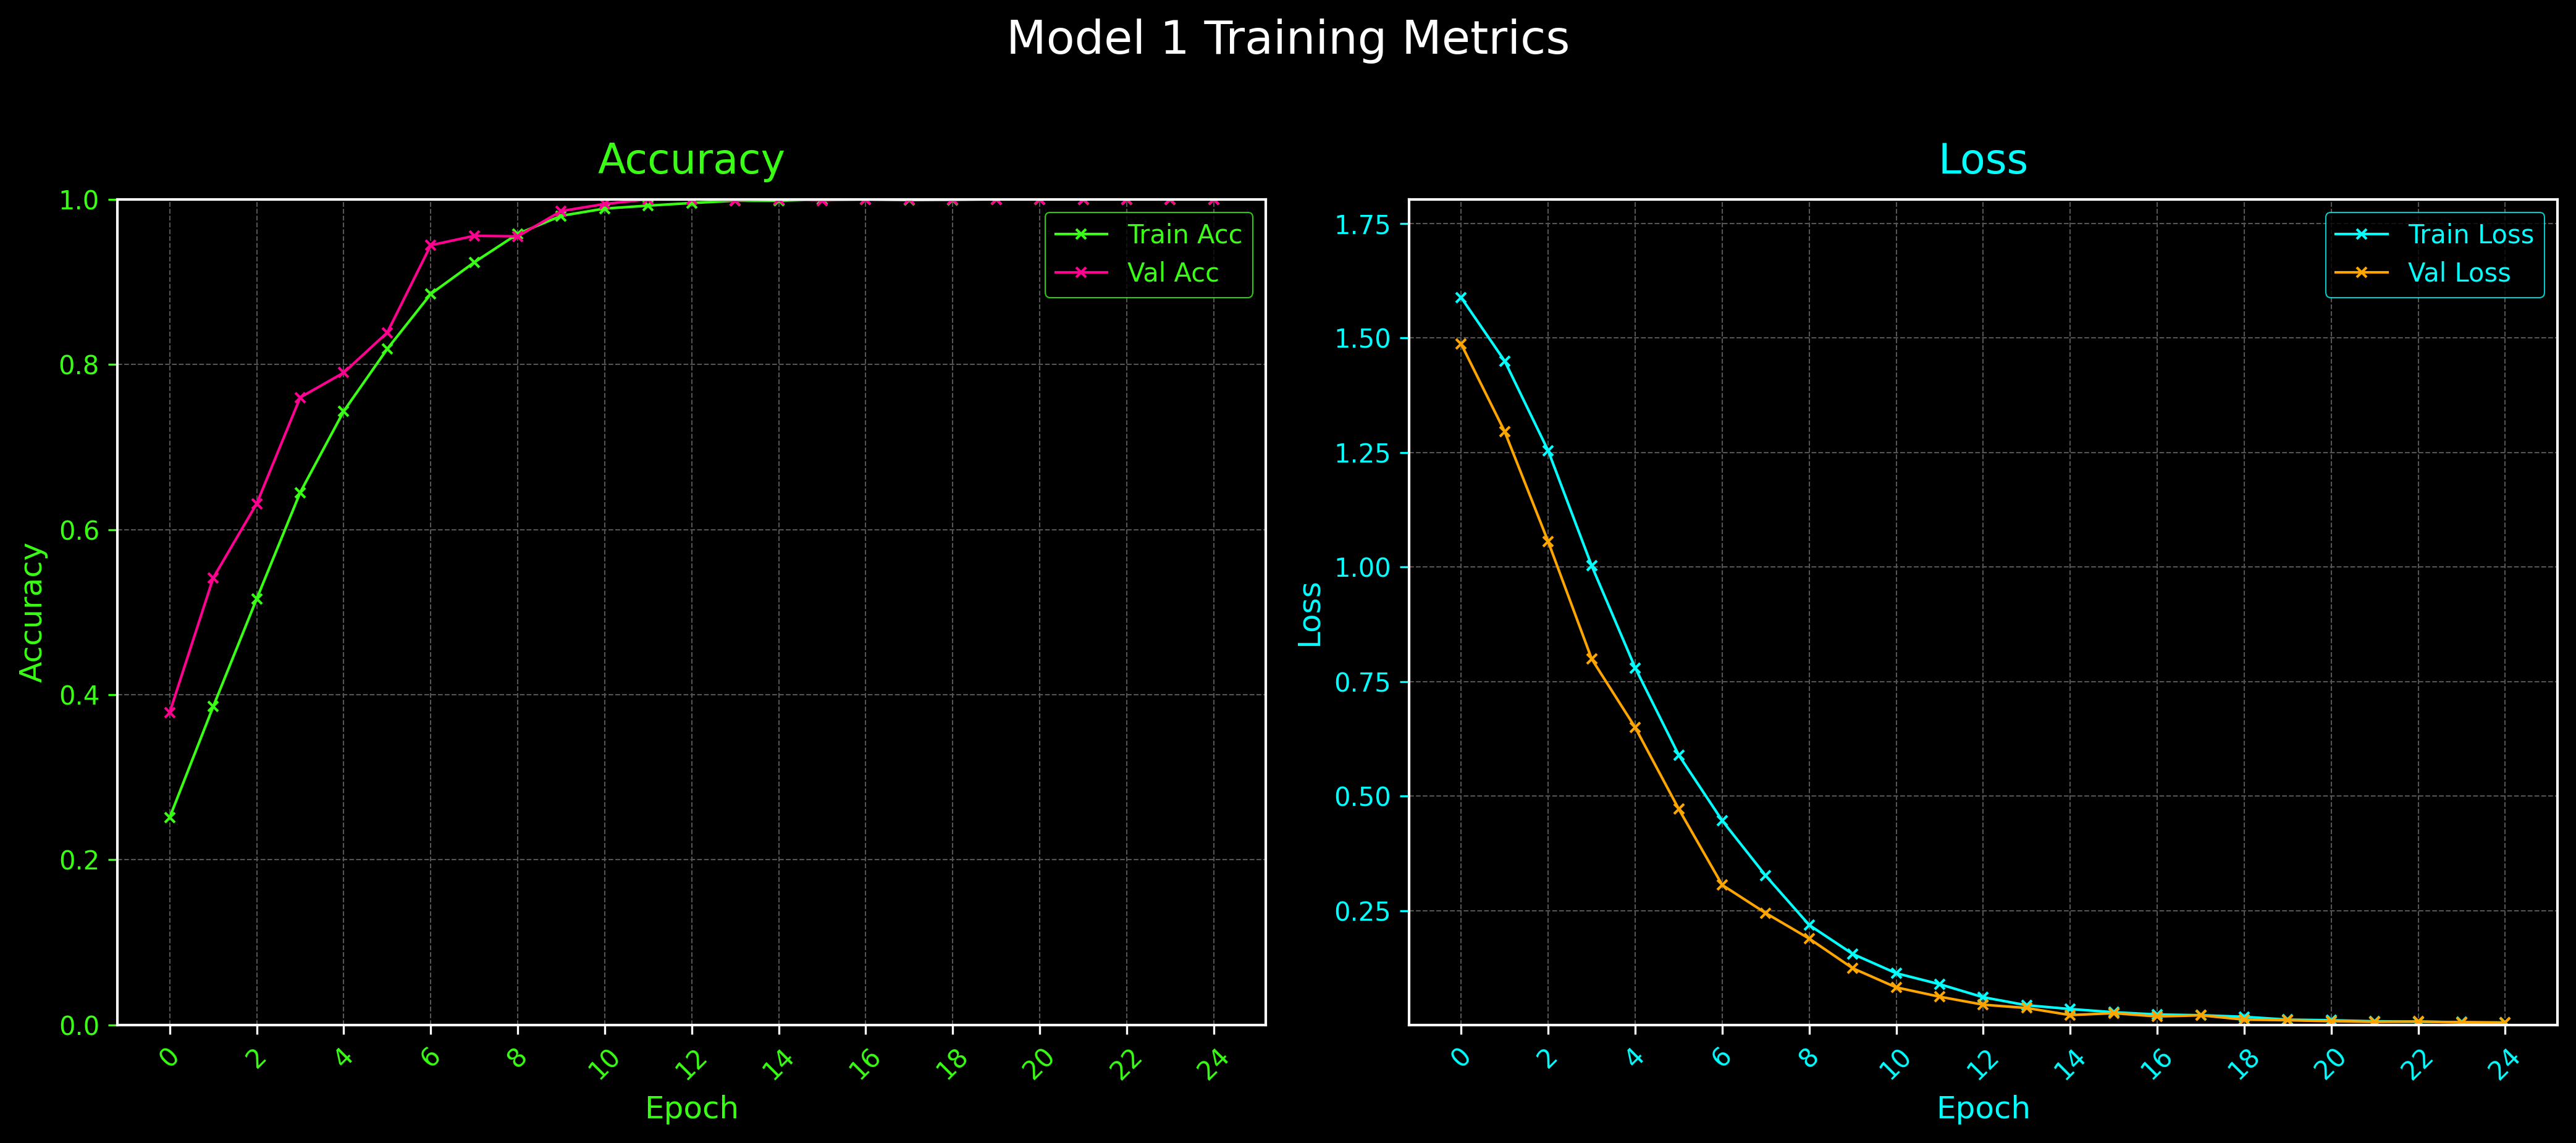

In [104]:
plot_modelMetrics(h1,title='Model 1 Training Metrics',fname='model1_metrics.png')

In [111]:
mdl1_eval = model_1.evaluate(p_val_grscl)
mdl2_eval = model_2.evaluate(p_val_grscl)
mdl3_eval = model_3.evaluate(p_val_grscl)
mdl4_eval = model_4.evaluate(p_val_grscl)

36/36 [==============================] - 6s 147ms/step - loss: 1.4550 - accuracy: 0.3989 - auc: 0.7638


In [156]:
import matplotlib.pyplot as plt

def plot_models_evaluation(models_eval, title="Models evaluation",
                           title_fs=20, label_fs=14, tick_fs=12, bar_width=0.6,
                          fname="Models_evaluation.png",normalize=False):
    max_loss = max(metrics[0] for metrics in models_eval.values())
    loss_label = "loss"
    if normalize :
        loss_label = f"Loss/Max_Loss({max_loss:.1f}) %"
    
    """
    Plots evaluation metrics (Loss, Accuracy, AUC) for multiple models
    with adjustable font sizes and bar widths.
    """
    # Convert dict to list of tuples if necessary
    if isinstance(models_eval, dict):
        items = list(models_eval.items())
    else:
        items = models_eval

    # Neon color palette
    neon_colors = [
        "#BFFF00", "#E500FF", "#76FF7A", "#00FFEF",
        "#39FF14", "#FF6EC7", "#04D9FF", "#F4F142",
        "#FF3131", "#FF5F1F",
    ]
    categories = [loss_label, "Accuracy", "AUC"]
    num_eval   = len(items)
    rows       = num_eval // 2 + num_eval % 2
    cols       = 2 if num_eval > 1 else 1

    # Create subplots
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(cols * 6, rows * 4),
        dpi=300,
        facecolor='black'
    )
    # Flatten axes array
    if hasattr(axes, 'flatten'):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Style each subplot
    for ax, color in zip(axes, neon_colors):
        ax.set_facecolor('black')
        ax.grid(True, color=color, linestyle='--', linewidth=0.5)

    # Plot each model's evaluation
    for i, (model_name, evaluation) in enumerate(items):
        if normalize:
            evaluation = [
                val / max_loss if val > 1 else val
                for val in evaluation
            ]
        ax = axes[i]
        count = min(len(evaluation), len(categories))
        ax.bar(
            categories[:count],
            evaluation[:count],
            color=neon_colors[i],
            width=bar_width  # Adjust bar width here
        )
        # Axis labels and title with adjustable font sizes
        #ax.set_xlabel('Metrics', color='white', fontsize=label_fs)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Score', color='white', fontsize=label_fs)
        ax.set_title(model_name, color=neon_colors[i], fontsize=label_fs + 2)
        # Tick label sizes
        ax.set_xticks(categories[:count])
        ax.set_xticklabels(categories[:count], color='white', fontsize=tick_fs)
        ax.tick_params(axis='y', colors='white', labelsize=tick_fs)

    # Figure title with adjustable font size
    fig.suptitle(title, color='white', fontsize=title_fs, y=1.02)
    plt.tight_layout()
    plt.show()
    fig.savefig(
        fname,
        dpi=300,
        facecolor=fig.get_facecolor(),
        edgecolor='black',
        bbox_inches='tight'
    )


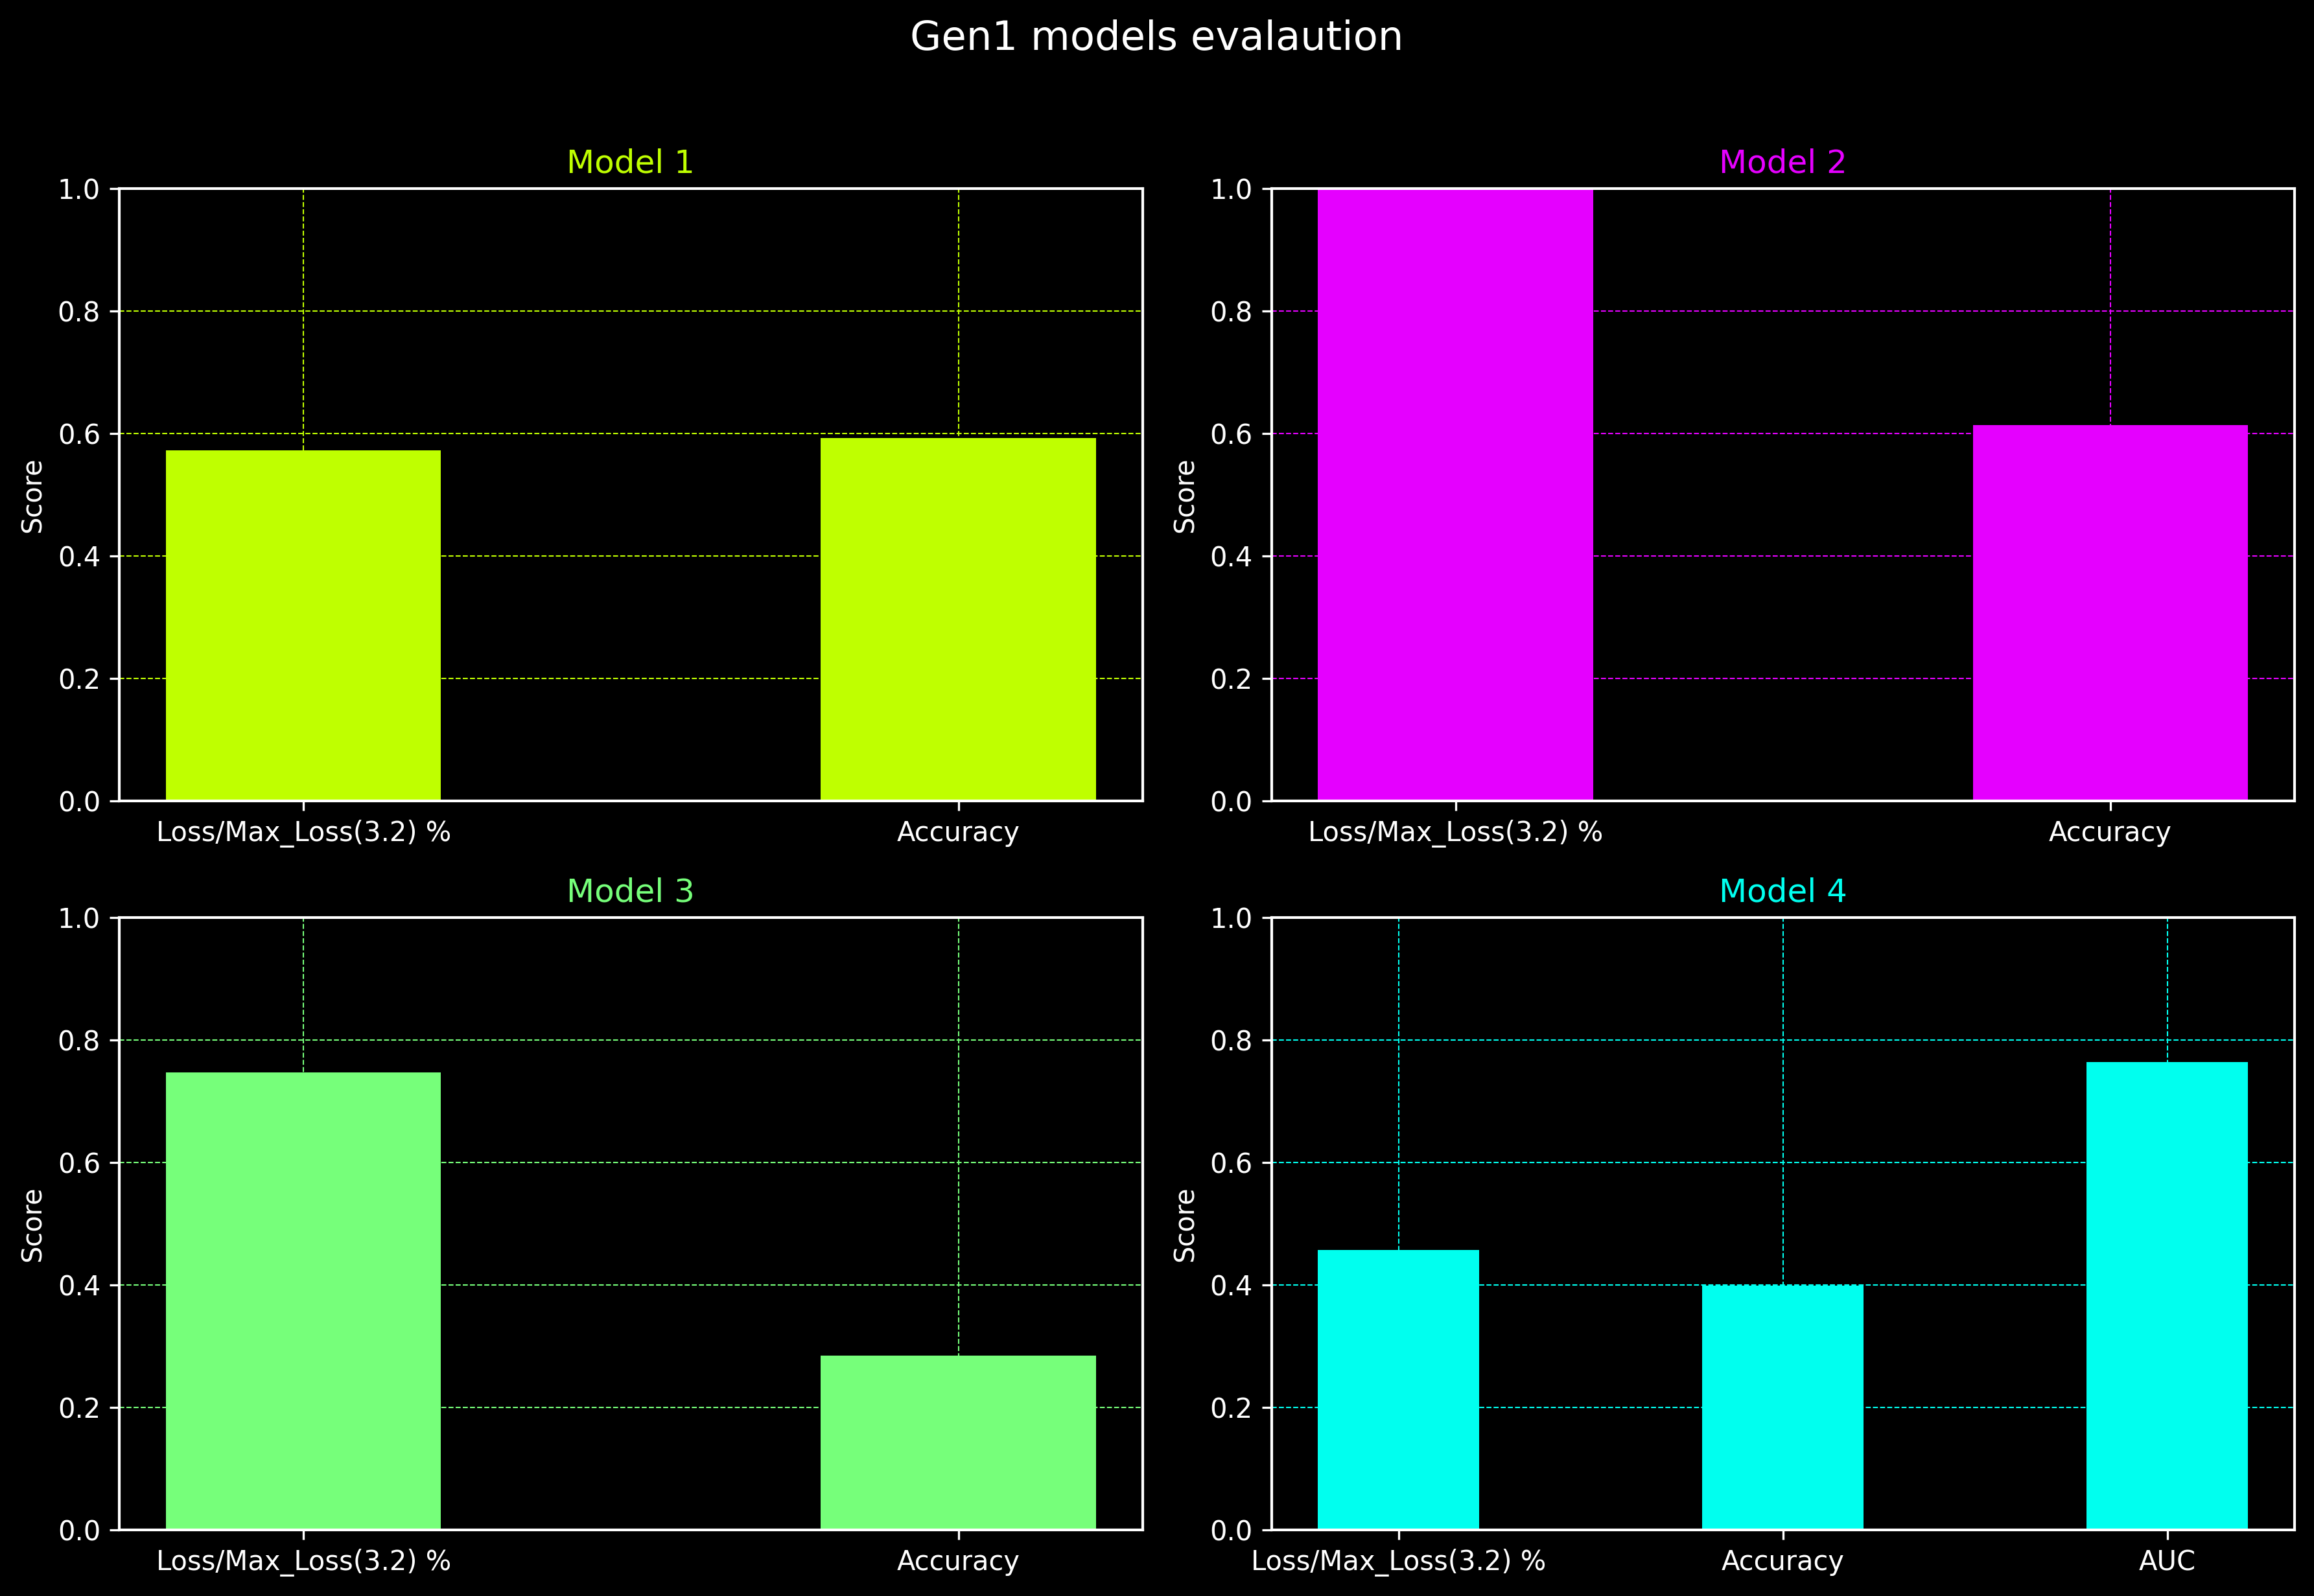

In [157]:
gen1_models_eval = {
    "Model 1":mdl1_eval,
    "Model 2":mdl2_eval,
    "Model 3":mdl3_eval,
    "Model 4":mdl4_eval
}
plot_models_evaluation(models_eval=gen1_models_eval,title="Gen1 models evalaution",fname="gen1_mdls_eval.png",
                       title_fs = 15,tick_fs = 10,label_fs=10,bar_width=0.42,
                       normalize=True)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_cm(model,data,input_color,title="Model"):
    data_size = len(data)
    val_size  = int(data_size * 0.2)
    shuffled  = data.shuffle(buffer_size=data_size, seed=42)
    val       = shuffled.take(val_size).prefetch(tf.data.AUTOTUNE)
    

    rebatch_val = val.batch(val_size)
    

    x_batch, y_batch = next(iter(rebatch_val))
    X_val = x_batch.numpy()                     
    y_true = np.argmax(y_batch.numpy(), axis=1) 
    
    y_prob = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    
    cm = confusion_matrix(y_true, y_pred, normalize='true') * 100
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=data.class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.figure(figsize=(5,5))
    disp.plot(ax=ax,
              cmap = input_color,
              xticks_rotation=45,
              values_format='.2f')  
    ax.set_title("Confusion Matrix (in % of true class)")
    plt.tight_layout()
    plt.show()
    fig.savefig(
        fname,
        dpi=300,
        facecolor=fig.get_facecolor(),
        edgecolor='black',
        bbox_inches='tight'
    )
    
    

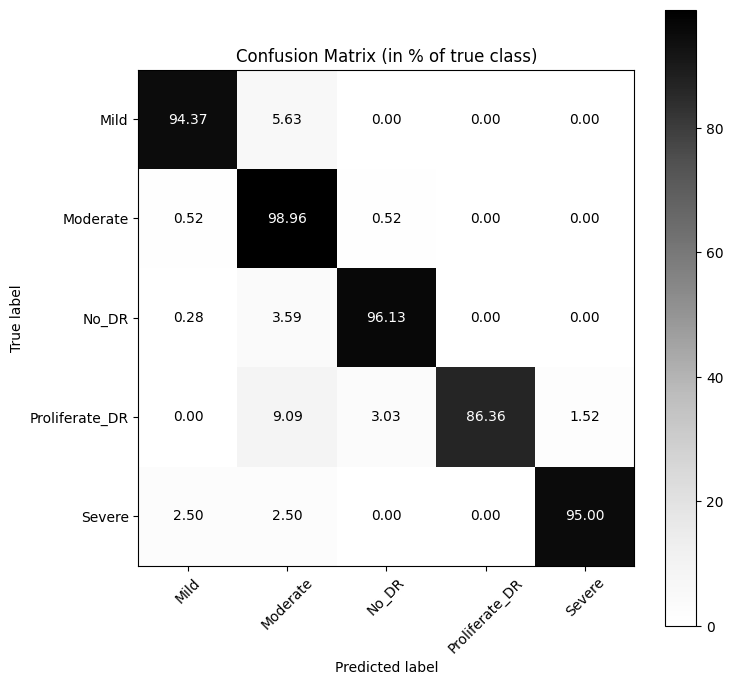

<Figure size 500x500 with 0 Axes>

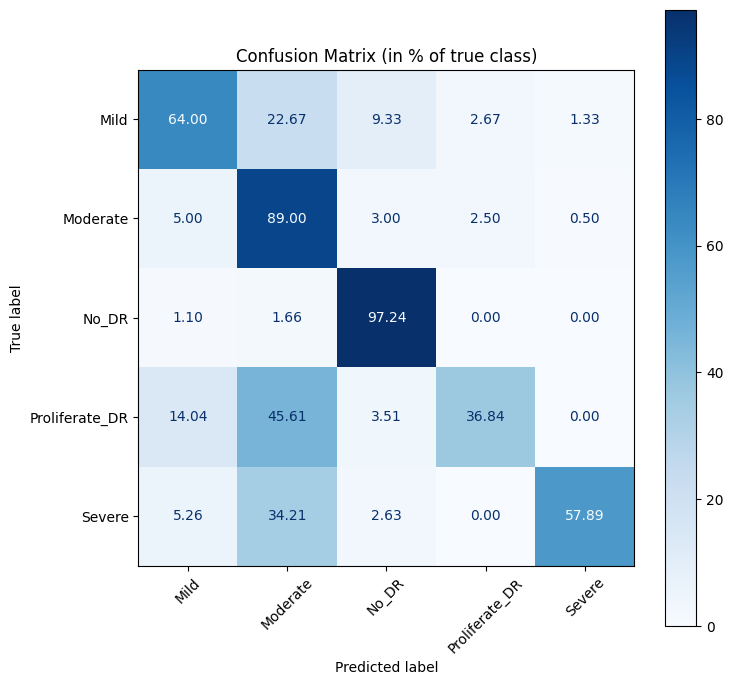

<Figure size 500x500 with 0 Axes>

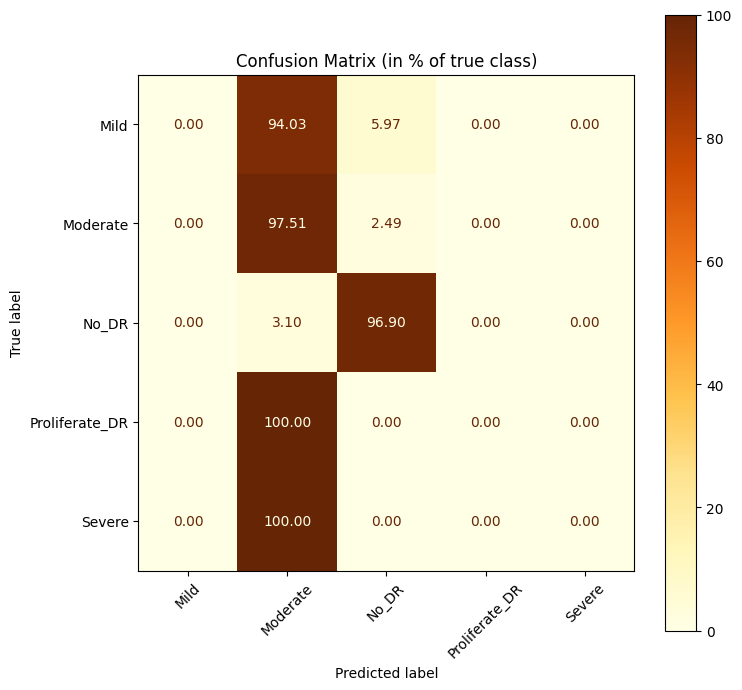

<Figure size 500x500 with 0 Axes>

In [148]:
plot_cm(model=model_1,data=data,input_color = plt.cm.Greys)
plot_cm(model=model_2,data=data,input_color = plt.cm.Blues)
plot_cm(model=model_3,data=data,input_color = plt.cm.YlOrBr)